# **Shopifty Data Science Intern Challenge**

Notebook by: Nicolas Palmar

### **Question 1**

On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis. 

a. Think about what could be going wrong with our calculation. Think about a better way to evaluate this data. 

b. What metric would you report for this dataset?

c. What is its value?


### **Solution Explanation**

# 1a: What is going wrong with AOV?
**Refer to data_exploration.ipynb to see exploratory data analysis details**


- After visualizing the data (**data_exploration.ipynb**), it is clear that there are outliers in the dataset causing the mean and standard deviation to be very large

- Due to finding outliers in shoe costs and shoe quantities (see aggregations and isolation forest outputs in data_exploration.ipynb), **means/averages should not be used** to evalute any metric on the data
- To better evalute this data, **methods that look for central values** and ignore outliers (like medians) would be much more appropriate
- Since skewed data can be unskewed by applying logarithmic transformations, consider applying a **logarithmic transformation** to minimize the effects caused by the outliers 

In [1]:
import pandas as pd  
import seaborn as sns

In [56]:
shoe_orders_df = pd.read_csv('q1_data_set.csv')

### Look at the standard deviation of the order amount to see how spread the data is
- To quantify how much outliers are affecting the average order value (AOV) check the standard deviation
- Note: High standard deviations is highly affected by outliers

In [3]:
shoe_orders_df.describe()

,order_id,shop_id,user_id,order_amount,total_items
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,2500.500000,50.078800,849.092400,3145.128000,8.78720
std,1443.520003,29.006118,87.798982,41282.539349,116.32032
min,1.000000,1.000000,607.000000,90.000000,1.00000
25%,1250.750000,24.000000,775.000000,163.000000,1.00000
50%,2500.500000,50.000000,849.000000,284.000000,2.00000
75%,3750.250000,75.000000,925.000000,390.000000,3.00000
max,5000.000000,100.000000,999.000000,704000.000000,2000.00000


- As described by the question, the mean order_amount is $3145.13
- Both the order cost mean and order quantity mean are very high
- The standard deviations for both order cost and order quantity are also very high. From the previous data exploration, outliers are the cause of this

# 1b/c: What Metric? What Value?

I have tried the 3 metrics listed below which agree on **$285 being the value for the improved AOV metric**

**i. Outlier Removed AOV, $287.72**: Use Isolation forrest to remove outliers and calculate AOV with outliers removed

**ii. Median Order Value, $284.00**: Use the median order value metric as it will not be affected by outliers - rather it will look for the central values in the dataset 

**iii. Exponential Mean Logged Order Value, $285.02**: Take the logarithm of order value and then the average of these logged order values. Reapply the exponential function to the final result to get the exponential mean log metric. 

## **i. Outlier Removed AOV**
**To get the outliers, I can train an isolation forest on the order amount**
- By removing certain % of outliers and plotting the resulting standard deviations/means, I can get an idea for the outlier removed AOV

In [82]:
from sklearn.ensemble import IsolationForest
from typing import Tuple

def make_isolation_forest(df: pd.DataFrame, n_estimators: int, contamination: float) -> pd.DataFrame:
    # create an isolation forest model
    detector = IsolationForest(n_estimators=n_estimators, contamination=contamination, random_state=8)
    detector.fit(df[['order_amount']])
    # use the fitted isolation forest and add it to the df to see the outliers
    outlier_df = df.copy()
    outlier_df['outlier'] = detector.predict(outlier_df[['order_amount']])
    outlier_df['score'] = detector.decision_function(outlier_df[['order_amount']])

    return outlier_df

def get_iso_std_mean(outlier_df: pd.DataFrame) -> Tuple[int]:
    """
    Get the standard deviation and the mean for the results of the isolation forrest
    """
    outlier_amount = outlier_df.loc[outlier_df['outlier']==1, 'order_amount']
    outlier_std = outlier_amount.std()
    outlier_mean = outlier_amount.mean()
    return (outlier_std, outlier_mean)

In [59]:
# check how mean and standard deviation changes between different contamination percentages
import numpy as np 

outlier_percent = np.arange(0.0025, 0.1, 0.0025)
outlier_stds = np.array([])
outlier_means = np.array([])

for percent in outlier_percent:
    # get the standard deviation and mean of the order_amount for different contamination percentages
    outlier_std, outlier_mean = get_iso_std_mean(make_isolation_forest(shoe_orders_df, 50, percent))
    outlier_stds = np.append(outlier_stds, outlier_std)
    outlier_means = np.append(outlier_means, outlier_mean)

outlier_stds.shape, outlier_stds[:5], outlier_percent[:5]

((39,),
 array([41282.53934879,  4627.72663406,  3293.57602137,  1579.39864616,
          160.80491181]),
 array([0.0025, 0.005 , 0.0075, 0.01  , 0.0125]))

- By looking at the first 5 standard deviations, we can see that it drops greatly when contamination goes from 0.01 -> 0.0125
- Choose 0.0125 (1.25%) as the starting point for the plots

In [58]:
fixed_idx = np.where(outlier_percent >= 0.0125)
outlier_percent_fixed = outlier_percent[fixed_idx]
outlier_stds_fixed = outlier_stds[fixed_idx]
outlier_means_fixed = outlier_means[fixed_idx]

## Plot Std and AOV without outliers
- Evidently, the plot below shows that by including all data, the outliers greatly affect standard deviation and AOV
- After removing 1.25% of outliers, standard deviation and AOV are relatively constant
- **AOV varies between $275-$300** (bottom right plot)

Text(0, 0.5, 'AOV')

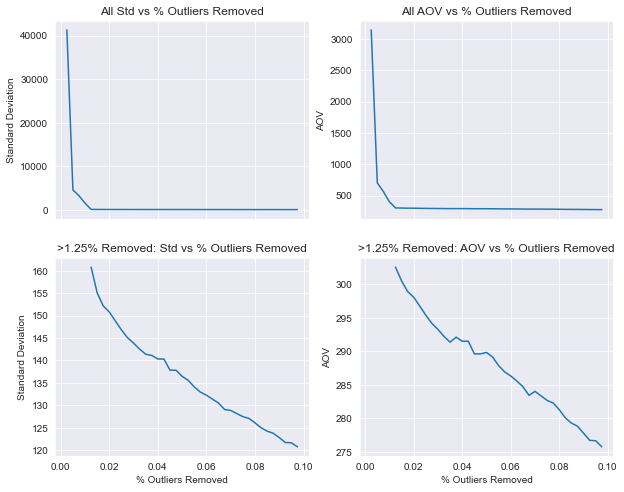

In [69]:
# plot the standard deviations and means
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
sns.set_style('darkgrid')
std_plot = sns.lineplot(x=outlier_percent_fixed, y=outlier_stds_fixed, ax=ax[1][0])
std_plot.set_title('>1.25% Removed: Std vs % Outliers Removed')
std_plot.set_xlabel('% Outliers Removed')
std_plot.set_ylabel('Standard Deviation')

all_std_plot = sns.lineplot(x=outlier_percent, y=outlier_stds, ax=ax[0][0])
all_std_plot.set_title('All Std vs % Outliers Removed')
all_std_plot.set_xlabel('% Outliers Removed')
all_std_plot.set_ylabel('Standard Deviation')

std_plot = sns.lineplot(x=outlier_percent_fixed, y=outlier_means_fixed, ax=ax[1][1])
std_plot.set_title('>1.25% Removed: AOV vs % Outliers Removed')
std_plot.set_xlabel('% Outliers Removed')
std_plot.set_ylabel('AOV')

all_std_plot = sns.lineplot(x=outlier_percent, y=outlier_means, ax=ax[0][1])
all_std_plot.set_title('All AOV vs % Outliers Removed')
all_std_plot.set_xlabel('% Outliers Removed')
all_std_plot.set_ylabel('AOV')

**I will now take the average between 1.25% and 10% of outliers removed from the AOV to calculate my outlier removed AOV metric**

In [80]:
outlier_removed_aov = outlier_means_fixed.mean()
print("i. Outlier Removed AOV:" + " $" +  str(round(outlier_removed_aov, 2)))

i. Outlier Removed AOV: $287.72


## **ii. Median Order Value**

- Since the initial task was to calculate average order value, Shopify likely wants to understand more about **average user spending habits**
- Median order value will give direct insight into average user spending habits - by using a median I am in effect **removing the small number of outliers in order amount** and getting a value that is much more representative of the majority of user spending habits
- Much more **robust** measure than the mean

In [81]:
median_ov = shoe_orders_df['order_amount'].median()
print("ii. Median Order Value:" + " $" +  str(round(median_ov, 2)))

ii. Median Order Value: $284.0


## **iii. Exponential Mean Logged Order Value**

- Logaritmic transformations are often applied to datasets with skewed distributions to turn them into normal distributions
- Although this dataset is not 'skewed', the inital logarithmic transformation will still reduce the effects of outliers and provided a more representative metric
- I then take the mean of the log transformed order_amounts and then reapply the exponential to get the exponential mean log metric

In [84]:
def exp_mean_logged(shoe_df: pd.DataFrame) -> np.float64:
    """
    Apply a logarithmic transformation, then take the mean, then reapply an exponential transformation
    """
    order_amt = np.array(shoe_df['order_amount'])
    try:
        logged_amt = np.log(order_amt)
        mean_logged_amt = logged_amt.mean()
        exp_mean_logged_amt = np.exp(mean_logged_amt)
    except:
        print("Error applying log")
    
    return exp_mean_logged_amt

In [85]:
exp_mean_log_metric = exp_mean_logged(shoe_orders_df)
print("iii. Exponential mean logged: " + "$" + str(round(exp_mean_log_metric, 2)))

iii. Exponential mean logged: $285.02
